In [304]:
import os, sklearn, math
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from joblib import dump, load

tf.random.set_seed(42)

data = '230704_Axial_z2_Data'
dataname = data+'_01'
filename = 'myData/'+data+'.csv'
SD1 = pd.read_csv(filename)
SD1=SD1.iloc[:,:12]
SensorData1 = SD1

In [305]:
SDreal = SD1

In [306]:
SDreal.describe()

,Sx00,Sx01,Sx02,Sx03,Sx04,Sx05,Sx06,Force,encoder,z,theta,r
count,202131.000000,202095.000000,202080.000000,202151.000000,202090.000000,202079.000000,202115.000000,202259.000000,202259.000000,202259.000000,202259.0,202259.000000
mean,42.754535,44.259789,48.249025,39.070789,43.258118,41.886005,49.292215,74.761637,-3206.817161,69.618202,0.0,4.791089
std,68.031985,104.297951,94.394885,79.269768,68.043460,87.230449,104.235657,67.992472,3845.800704,40.996144,0.0,2.064388
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,19.000000,-483.760000,-11501.980000,0.000000,0.0,1.600000
25%,40.000000,40.000000,44.000000,36.000000,40.000000,37.000000,46.000000,36.460000,-5916.270000,34.000000,0.0,3.200000
50%,42.000000,43.000000,47.000000,38.000000,43.000000,40.000000,49.000000,72.720000,-2402.310000,70.000000,0.0,4.800000
75%,44.000000,45.000000,49.000000,41.000000,45.000000,45.000000,51.000000,110.960000,421.700000,106.000000,0.0,6.400000
max,8191.000000,8191.000000,8191.000000,8191.000000,8191.000000,8191.000000,8191.000000,9998.550000,1642.320000,140.000000,0.0,8.000000


In [307]:
# SDreal 값이 0보다 작은 것 제거
SDreal = SDreal[~((SDreal < 0)&(SDreal.columns != "encoder")).any(axis=1)]

# SDreal 값이 100보다 크거나 0인데, 'theta', 'z', 'Force' 열이 아닌 것 제거
SDreal = SDreal[~(((SDreal >= 100)|(SDreal == 0) ) & 
                 (SDreal.columns != "theta") &
                 (SDreal.columns != "z") &
                 (SDreal.columns != "Force") &
                  (SDreal.columns != "encoder")).any(axis=1)]

# SDreal 값이 8191이거나 8190인 것 제거
SDreal = SDreal[~((SDreal == 8191) | (SDreal == 8190)).any(axis=1)]

SDreal = SDreal[~((SDreal >= 800) & (SDreal.columns == "Force")).any(axis=1)]
# SDreal에서 결측값 제거
SDreal = SDreal[~SDreal.isna().any(axis=1)]

SDreal = SDreal[SDreal["r"] >= 0.8*4]
SDreal = SDreal[SDreal["z"] <= 130]
SDreal = SDreal[SDreal["z"] >= 30]
SDreal.describe()

,Sx00,Sx01,Sx02,Sx03,Sx04,Sx05,Sx06,Force,encoder,z,theta,r
count,111783.000000,111783.000000,111783.000000,111783.000000,111783.000000,111783.000000,111783.000000,111783.000000,111783.000000,111783.000000,111783.0,111783.000000
mean,42.373814,41.952640,45.504504,37.249269,42.237353,40.784332,48.446642,97.272692,-3739.456639,79.838902,0.0,5.593373
std,2.883283,4.230405,3.618296,3.616584,3.818099,4.833580,3.643784,30.764643,3068.981364,29.467676,0.0,1.599510
min,3.000000,14.000000,6.000000,17.000000,6.000000,11.000000,19.000000,43.250000,-10107.070000,30.000000,0.0,3.200000
25%,41.000000,39.000000,43.000000,35.000000,40.000000,37.000000,47.000000,70.120000,-5906.070000,54.000000,0.0,4.000000
50%,42.000000,42.000000,46.000000,38.000000,43.000000,40.000000,49.000000,97.210000,-4055.540000,80.000000,0.0,5.600000
75%,44.000000,45.000000,48.000000,40.000000,45.000000,44.000000,51.000000,126.640000,-738.280000,106.000000,0.0,7.200000
max,69.000000,76.000000,77.000000,65.000000,75.000000,57.000000,69.000000,171.200000,853.330000,130.000000,0.0,8.000000


In [308]:
def moving_average(group, window_size=5):
    cols = ['Sx00', 'Sx01', 'Sx02', 'Sx03', 'Sx04', 'Sx05', 'Sx06']
    for col in cols:
        group[col + '_MA'] = group[col].rolling(window_size).mean()
    return group

SDreal = SDreal.groupby(['z', 'r']).apply(moving_average)
SDreal = SDreal[~SDreal.isna().any(axis=1)]

In [309]:
def normalize_dataframe(df, columns):
    for column in columns:
        df[column] = (df[column] - df[column].mean()) / (df[column].max() - df[column].min()) * 2
    return df


#SDreal_normalized = normalize_dataframe(SDreal)
SDreal_normalized = normalize_dataframe(SDreal, ['r', 'Force', 'z'])
SDreal = SDreal_normalized
SDreal

,Sx00,Sx01,Sx02,Sx03,Sx04,Sx05,Sx06,Force,encoder,z,theta,r,Sx00_MA,Sx01_MA,Sx02_MA,Sx03_MA,Sx04_MA,Sx05_MA,Sx06_MA
43875,41.0,43.0,49.0,36.0,41.0,42.0,49.0,-0.747680,737.75,-0.996736,0,-0.997203,41.6,47.8,46.0,37.6,43.0,43.2,49.2
43876,41.0,43.0,49.0,38.0,41.0,42.0,49.0,-0.746710,737.75,-0.996736,0,-0.997203,41.6,47.8,46.0,37.2,42.6,42.8,48.6
43877,43.0,48.0,47.0,38.0,41.0,42.0,50.0,-0.748003,737.75,-0.996736,0,-0.997203,41.8,47.2,46.6,36.8,42.2,42.4,49.0
43878,43.0,48.0,47.0,42.0,41.0,46.0,50.0,-0.750911,737.75,-0.996736,0,-0.997203,42.0,46.6,47.2,38.0,41.6,43.0,49.4
43879,43.0,40.0,47.0,42.0,41.0,46.0,47.0,-0.751719,737.75,-0.996736,0,-0.997203,42.2,44.4,47.8,39.2,41.0,43.6,49.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
188260,31.0,33.0,47.0,36.0,45.0,40.0,51.0,0.455035,-10105.49,1.003264,0,1.002797,34.2,34.0,47.4,35.8,47.0,34.4,49.8
188261,31.0,33.0,47.0,36.0,45.0,40.0,50.0,0.454712,-10105.75,1.003264,0,1.002797,33.0,33.8,47.2,36.6,46.8,36.0,50.2
188262,34.0,36.0,47.0,34.0,44.0,40.0,50.0,0.455197,-10106.10,1.003264,0,1.002797,32.6,34.0,47.0,36.0,46.0,37.6,50.6
188263,34.0,36.0,48.0,34.0,44.0,32.0,49.0,0.454712,-10106.63,1.003264,0,1.002797,32.2,34.2,47.2,35.4,45.2,37.2,50.2


In [310]:
SDy = SDreal.iloc[:,[7,9]]
SDy.describe()

,Force,z
count,1.103550e+05,1.103550e+05
mean,-2.116172e-14,-2.987872e-14
std,4.956829e-01,5.893608e-01
min,-8.711345e-01,-9.967364e-01
25%,-4.375884e-01,-5.167364e-01
50%,-3.257353e-04,3.263649e-03
75%,4.747490e-01,5.232636e-01
max,1.128866e+00,1.003264e+00


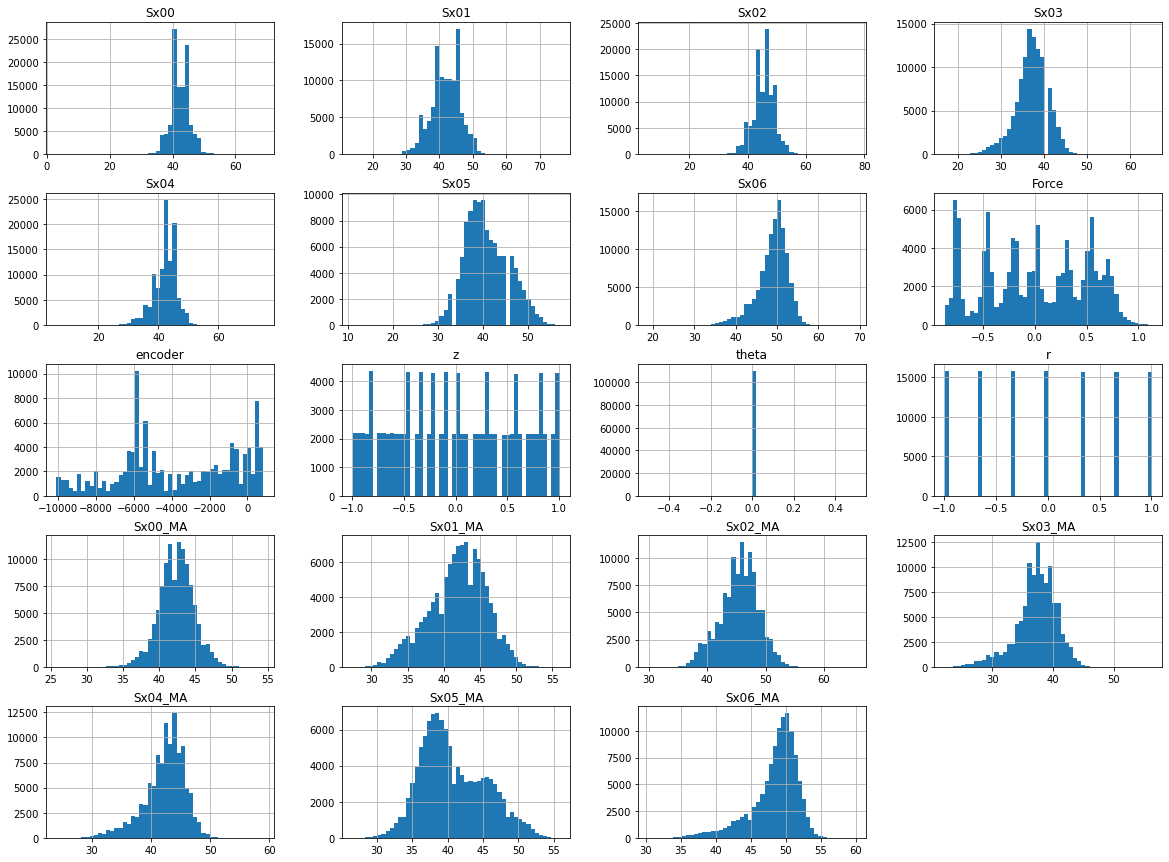

In [311]:
%matplotlib inline
import matplotlib.pyplot as plt
SDreal.hist(bins=50, figsize=(20,15))
plt.savefig('D:/ME program/2017-PhD/01_research/02Study/34_ballon_like_cover/DeepLearing/SensorCallbi/LABS_v3/savefig/'+dataname+'_hist230320.png')
plt.show()

In [312]:
X = SDreal.iloc[:,12:19]
y = SDreal.iloc[:,[7,9]]

In [313]:
X

,Sx00_MA,Sx01_MA,Sx02_MA,Sx03_MA,Sx04_MA,Sx05_MA,Sx06_MA
43875,41.6,47.8,46.0,37.6,43.0,43.2,49.2
43876,41.6,47.8,46.0,37.2,42.6,42.8,48.6
43877,41.8,47.2,46.6,36.8,42.2,42.4,49.0
43878,42.0,46.6,47.2,38.0,41.6,43.0,49.4
43879,42.2,44.4,47.8,39.2,41.0,43.6,49.0
...,...,...,...,...,...,...,...
188260,34.2,34.0,47.4,35.8,47.0,34.4,49.8
188261,33.0,33.8,47.2,36.6,46.8,36.0,50.2
188262,32.6,34.0,47.0,36.0,46.0,37.6,50.6
188263,32.2,34.2,47.2,35.4,45.2,37.2,50.2


In [314]:
y.sample(5)

,Force,z
56572,-0.016970,-0.836736
95929,-0.432256,-0.276736
160706,-0.769656,0.643264
111425,0.571865,-0.076736
151265,0.491393,0.483264


In [315]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size = 0.01, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, test_size = 0.2, random_state=42)
X_sum = len(X_train)+len(X_valid)+len(X_test)
X_train_per = int(len(X_train)/X_sum*100)
X_valid_per = int(len(X_valid)/X_sum*100)
X_test_per = int(len(X_test)/X_sum*100)

print('X_train: ',len(X_train),'ea',X_train_per,'%   ', 
      'X_valid: ',len(X_valid),'ea',X_valid_per,'%   ',
      'X_test: ',len(X_test),'ea',X_test_per,'%',)

X_train:  87400 ea 79 %    X_valid:  21851 ea 19 %    X_test:  1104 ea 1 %


In [316]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

In [317]:
import pickle
from joblib import dump, load

file_name = 'myScaler/'+dataname+'_SS.pkl'
dump(scaler, file_name)

['myScaler/230704_Axial_z2_Data_01_SS.pkl']

In [318]:
from tensorflow import keras
model = keras.models.Sequential([      
    keras.layers.Dense(16, activation="relu", input_shape=X_train.shape[1:],kernel_initializer = "he_normal"),        
    keras.layers.Dense(16, activation="relu", input_shape=X_train.shape[1:],kernel_initializer = "he_normal"),        
    keras.layers.Dense(8, activation="relu", input_shape=X_train.shape[1:],kernel_initializer = "he_normal"),        
    keras.layers.Dense(4, activation="relu", input_shape=X_train.shape[1:],kernel_initializer = "he_normal"),            
    keras.layers.Dense(2)
])
model.compile(loss="mean_squared_error", optimizer=keras.optimizers.RMSprop(learning_rate=1e-3, rho=0.9))
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_83 (Dense)            (None, 16)                128       
                                                                 
 dense_84 (Dense)            (None, 16)                272       
                                                                 
 dense_85 (Dense)            (None, 8)                 136       
                                                                 
 dense_86 (Dense)            (None, 4)                 36        
                                                                 
 dense_87 (Dense)            (None, 2)                 10        
                                                                 
Total params: 582
Trainable params: 582
Non-trainable params: 0
_________________________________________________________________


## Callback (best, early stopping, tensorboard)

In [319]:
import os 
#root_logdir = os.path.join(os.curdir, 'mylog/'+data)
root_logdir = os.path.join(os.curdir, 'mylog/'+'230320_Data')

def get_run_logdir():
    import time
    run_id= time.strftime("%m%d_%Hh%Mm%Ss"+dataname)
    return os.path.join(root_logdir, run_id)

run_logdir = get_run_logdir()

In [320]:
K = keras.backend
class OneCycleScheduler(keras.callbacks.Callback):
    def __init__(self, iterations, max_rate, start_rate=None,
                 last_iterations=None, last_rate=None):
        self.iterations = iterations
        self.max_rate = max_rate
        self.start_rate = start_rate or max_rate / 10
        self.last_iterations = last_iterations or iterations // 10 + 1
        self.half_iteration = (iterations - self.last_iterations) // 2
        self.last_rate = last_rate or self.start_rate / 1000
        self.iteration = 0
    def _interpolate(self, iter1, iter2, rate1, rate2):
        return ((rate2 - rate1) * (self.iteration - iter1)
                / (iter2 - iter1) + rate1)
    def on_batch_begin(self, batch, logs):
        if self.iteration < self.half_iteration:
            rate = self._interpolate(0, self.half_iteration, self.start_rate, self.max_rate)
        elif self.iteration < 2 * self.half_iteration:
            rate = self._interpolate(self.half_iteration, 2 * self.half_iteration,
                                     self.max_rate, self.start_rate)
        else:
            rate = self._interpolate(2 * self.half_iteration, self.iterations,
                                     self.start_rate, self.last_rate)
        self.iteration += 1
        K.set_value(self.model.optimizer.learning_rate, rate)

In [321]:
dataname

'230704_Axial_z2_Data_01'

In [322]:
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
early_stopping_cb = keras.callbacks.EarlyStopping(patience = 10, restore_best_weights = True)
n_epochs = 300
batch_size = 32
onecycle = OneCycleScheduler(math.ceil(len(X_train) / batch_size) * n_epochs, max_rate=0.05)
history = model.fit(X_train, y_train, epochs=n_epochs,
                    validation_data=(X_valid, y_valid),
                    callbacks=[onecycle,early_stopping_cb,tensorboard_cb])
mse_test = model.evaluate(X_test, y_test)
X_new = X_test[:5]
y_pred = model.predict(X_new)

Epoch 1/300
2732/2732 [==============================] - 4s 1ms/step - loss: 0.0681 - val_loss: 0.0546
Epoch 2/300
2732/2732 [==============================] - 3s 1ms/step - loss: 0.0557 - val_loss: 0.0557
Epoch 3/300
2732/2732 [==============================] - 3s 1ms/step - loss: 0.0542 - val_loss: 0.0569
Epoch 4/300
2732/2732 [==============================] - 3s 1ms/step - loss: 0.0534 - val_loss: 0.0548
Epoch 5/300
2732/2732 [==============================] - 3s 1ms/step - loss: 0.0531 - val_loss: 0.0599
Epoch 6/300
2732/2732 [==============================] - 3s 1ms/step - loss: 0.0530 - val_loss: 0.0548
Epoch 7/300
2732/2732 [==============================] - 3s 1ms/step - loss: 0.0531 - val_loss: 0.0526
Epoch 8/300
2732/2732 [==============================] - 3s 1ms/step - loss: 0.0530 - val_loss: 0.0586
Epoch 9/300
2732/2732 [==============================] - 3s 1ms/step - loss: 0.0532 - val_loss: 0.0543
Epoch 10/300
2732/2732 [==============================] - 4s 1ms/step - l

In [323]:
# %load_ext tensorboard
# %tensorboard --logdir=./mylog/230320_Data --port=2322

In [324]:
model.save('D:/ME program/2017-PhD/01_research/02Study/34_ballon_like_cover/DeepLearing/TACTS/TACTS_v1/myModel/'+dataname+'.h5')

In [325]:
model = tf.keras.models.load_model('myModel/'+dataname+'.h5')
scaler = load(file_name)
valid_predictions = model.predict(X_valid)

683/683 [==============================] - 0s 606us/step


In [326]:
valid_predictions_df=pd.DataFrame(valid_predictions)
valid_predictions_df.columns = ["valid_force","valid_z"]
#valid_predictions_df.columns = ["valid_force","valid_z","valid_r"]

k= y_valid.to_numpy()
k_df = pd.DataFrame(k)
#k_df.columns = ["theta_enc","z","cos","sin"]
#k_df.columns  = ["force","z","r"]
k_df.columns  = ["force","z"]
#k_df.columns = ["r","theta_enc","z"]
#k_df.columns  = ["cos","sin"]
#k_df.columns  = ["theta_enc","z"]
#k_df.columns  = ["z"]
#k_df.columns  = ["theta_enc"]

ValidPre = pd.concat( [k_df,valid_predictions_df],axis=1)
ValidPre.head(5)
corr = ValidPre.corr()
print("corr")
n = k_df.shape[1]
for i in range(0,n):    
    print(format(corr[valid_predictions_df.columns[i]][k_df.columns[i]]*100,'.2f')+'%',k_df.columns[i])
corr

corr
90.11% force
91.81% z


,force,z,valid_force,valid_z
force,1.000000,-0.072776,0.901130,-0.099792
z,-0.072776,1.000000,-0.108827,0.918145
valid_force,0.901130,-0.108827,1.000000,-0.153465
valid_z,-0.099792,0.918145,-0.153465,1.000000


<AxesSubplot:xlabel='force', ylabel='valid_force'>

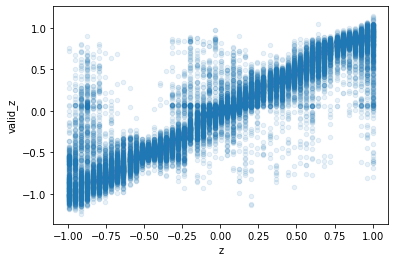

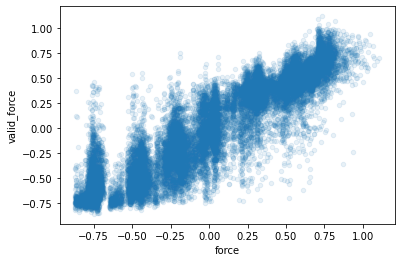

In [327]:
alpa=0.1
ValidPre.plot(kind="scatter", x= "z",y= "valid_z",alpha = alpa)
ValidPre.plot(kind="scatter", x= "force",y= "valid_force",alpha = alpa)
#ValidPre.plot(kind="scatter", x= "r",y= "valid_r",alpha = alpa)